In [ ]:
# imports
import glob
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pickle
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import gc
import random

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# unzip flickr faces data from drive to local colab memory
!unzip "/content/gdrive/MyDrive/flickr/archive (2).zip" -d "/content/gdrive/MyDrive/flickr_images"

In [ ]:
# unzip gan generated images stored in drive
!unzip "/content/gdrive/MyDrive/gan_gen_images/gan1.zip" -d "/content/gdrive/MyDrive/gan_final_images"
!unzip "/content/gdrive/MyDrive/gan_gen_images/gan2.zip" -d "/content/gdrive/MyDrive/gan_final_images"
!unzip "/content/gdrive/MyDrive/gan_gen_images/gan3.zip" -d "/content/gdrive/MyDrive/gan_final_images"
!unzip "/content/gdrive/MyDrive/gan_gen_images/gan4.zip" -d "/content/gdrive/MyDrive/gan_final_images"

In [ ]:
# set real images as flickr images and fake images as gan generated images

In [ ]:
training_real_dir = glob.glob("/content/gdrive/MyDrive/flickr_images/*")

In [ ]:
training_fake_dir = glob.glob("/content/gdrive/MyDrive/gan_final_images/GAN_generated_images/*")

In [ ]:
# create dataframe with paths to images
dataset = pd.DataFrame()
dataset['Image_ID'] = training_fake_dir
dataset['Label'] = "0"
dataset = dataset.append(pd.DataFrame({'Image_ID':training_real_dir[:5000], 'Label':"1"}), ignore_index=True)

In [ ]:
dataset

,Image_ID,Label
0,/content/gdrive/MyDrive/gan_final_images/GAN_g...,0
1,/content/gdrive/MyDrive/gan_final_images/GAN_g...,0
2,/content/gdrive/MyDrive/gan_final_images/GAN_g...,0
3,/content/gdrive/MyDrive/gan_final_images/GAN_g...,0
4,/content/gdrive/MyDrive/gan_final_images/GAN_g...,0
...,...,...
9996,/content/gdrive/MyDrive/flickr_images/04995.png,1
9997,/content/gdrive/MyDrive/flickr_images/04996.png,1
9998,/content/gdrive/MyDrive/flickr_images/04997.png,1
9999,/content/gdrive/MyDrive/flickr_images/04998.png,1


Cell taken from Jeff Heaton's notebook about StyleGan2-ADA:

Link to notebook with StyleGan2-ADA used to generate the face images: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_style_gan.ipynb

StyleGAN2 Generated Faces
![StyleGAN2 Generated Faces](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/stylegan2_images.jpg "StyleGAN2 Generated Faces")

The above images were generated with StyleGAN2, using Google CoLab.  


StyleGAN2 Faces with imperfections:
![StyleGAN2 Face](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_bad.jpg "StyleGAN2 Face")

* Image A demonstrates the very abstract backgrounds usually associated with a GAN generated image.
* Image B exhibits issues that earrings often present for GANs. GANs sometimes have problems with symmetry, particularly earrings.
* Image C contains an abstract background, as well as a highly distorted secondary image.
* Image D also contains a highly distorted secondary image that might be a hand.

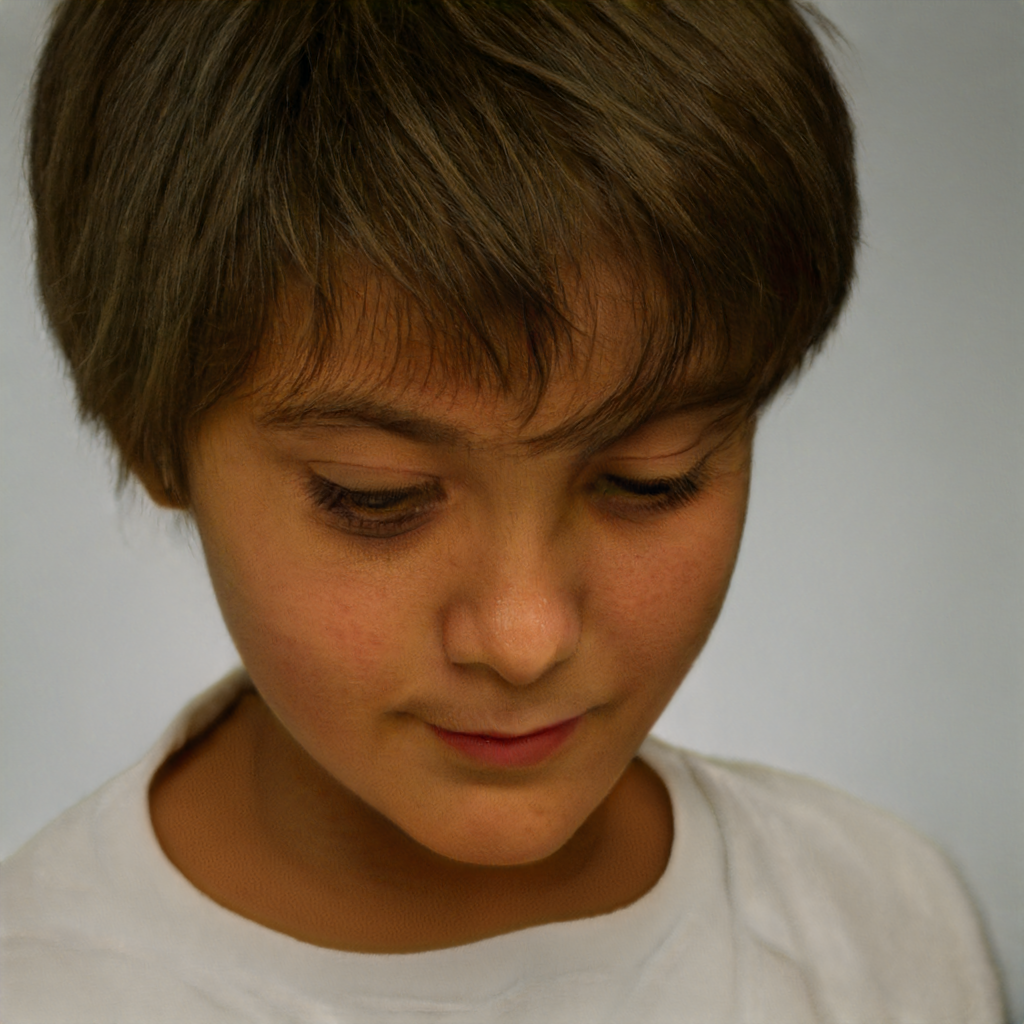

In [ ]:
# Sample GAN-generated image
Image.open(dataset.iloc[0]['Image_ID'])

In [ ]:
# shuffle the dataset
dataset = dataset.sample(frac=1)

In [ ]:
# load as 64x64x3 images and create numpy arrays to train
x_data = np.asarray([img_to_array(load_img(i, target_size=(64, 64))) for i in dataset['Image_ID']])
y_data = np.asarray([np.asarray(i) for i in dataset['Label']])
y_data = y_data.astype(np.float32)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
del x_data
del y_data

In [ ]:
# train model - 81.4% max accuracy
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model3 = keras.models.Sequential()
model3.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(units=512,activation="relu"))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dense(units=512,activation="relu"))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dense(units=128,activation="relu"))
model3.add(keras.layers.Dropout(0.5))
model3.add(keras.layers.Dense(units=32,activation="relu"))
model3.add(keras.layers.Dense(units=1, activation="sigmoid"))
model3.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
hist_deep = model3.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 1000,
  callbacks = [callback]
  )

Epoch 1/1000
282/282 [==============================] - 22s 74ms/step - loss: 0.7847 - accuracy: 0.5079 - val_loss: 0.7973 - val_accuracy: 0.5045
Epoch 2/1000
282/282 [==============================] - 20s 72ms/step - loss: 0.7236 - accuracy: 0.5073 - val_loss: 0.7063 - val_accuracy: 0.4895
Epoch 3/1000
282/282 [==============================] - 20s 72ms/step - loss: 0.7050 - accuracy: 0.5127 - val_loss: 0.7453 - val_accuracy: 0.4985
Epoch 4/1000
282/282 [==============================] - 20s 72ms/step - loss: 0.7011 - accuracy: 0.5104 - val_loss: 0.6932 - val_accuracy: 0.4935
Epoch 5/1000
282/282 [==============================] - 20s 72ms/step - loss: 0.6980 - accuracy: 0.5076 - val_loss: 0.7090 - val_accuracy: 0.5095
Epoch 6/1000
282/282 [==============================] - 20s 72ms/step - loss: 0.6980 - accuracy: 0.5064 - val_loss: 0.6950 - val_accuracy: 0.4925
Epoch 7/1000
282/282 [==============================] - 20s 72ms/step - loss: 0.6955 - accuracy: 0.5098 - val_loss: 0.6953 -

In [ ]:
vgg = tf.keras.applications.VGG16(input_shape = (64, 64, 3), include_top = False, weights = "imagenet")
averaging_layer = tf.keras.layers.Flatten()(vgg.output)
dense1 = tf.keras.layers.Dense(units = 512, activation = 'relu')(averaging_layer)
bn = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')(bn)
dense3 = tf.keras.layers.Dense(units = 256, activation = 'relu')(dense2)
dense4 = tf.keras.layers.Dense(units = 32, activation = 'relu')(dense3)
output = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(dense4)
combined_model = tf.keras.models.Model(inputs = vgg.input, outputs = output)
combined_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

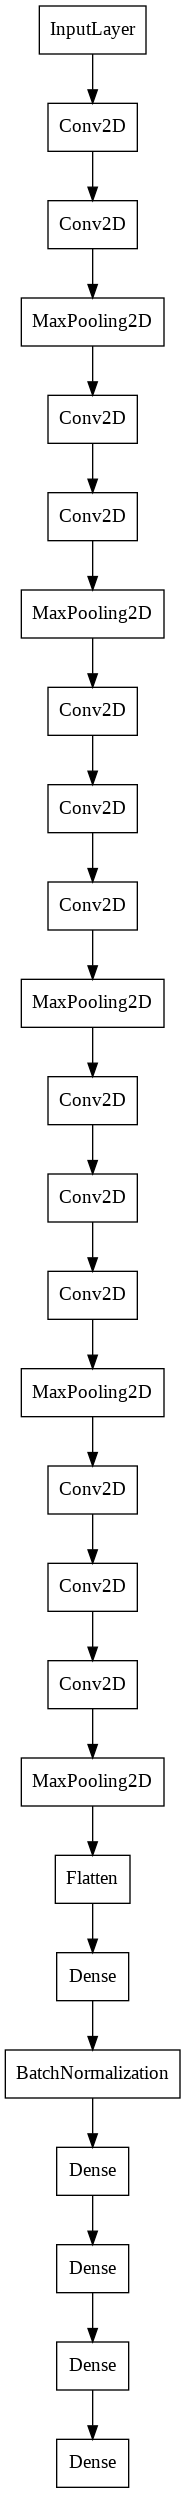

In [ ]:
plot_model(combined_model, to_file='model_tl.png', show_shapes=False, show_layer_names=False)